# Klasifikacija teksta

U ovoj svesci proći ćemo ponovo kroz primer koji smo uveli u priči o konvolutivnim neuronskim mrežama. Bavićemo se klasifikacijom IMDB filmskih pregleda na pozitivne i negativne, ali ovoga puta uz korišćenje rekurentnih neuronskih mreža. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [85]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, SimpleRNN, LSTM, GRU, Flatten
from keras.datasets import imdb
from keras import preprocessing

Ovaj paket ćemo iskoristiti za praćenje vremena traniranja.

In [3]:
from time import perf_counter

## Priprema skupa podataka

Podsetimo se da prilikom učitavanja skupova za učenje i testiranje treba naglasiti sa kojom veličinom vokabulara želimo da radimo. Vokabular je uređen opadajuće po frekvenciji pojavljivanja reči, a navedeni broj predstavlja broj reči sa početka vokabulara. Ovde se zbog ograničenja zadržavamo na prvih 10000 reči. 

In [4]:
max_features = 10000

In [5]:
(X_train, y_train), (X_test, y_test)= imdb.load_data(num_words=max_features)

In [6]:
print('Skup za treniranje: ', X_train.shape)
print('Skup za testriranje: ', X_test.shape)

Skup za treniranje:  (25000,)
Skup za testriranje:  (25000,)


Podsetimo se i da je jedan ovako učitani pregled niz indeksa reči vokabulara. Nulama su predstavljene reči koje nisu pokrivene vokabularom.

In [7]:
print(X_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [8]:
len(X_train[0])

218

Očekuje se i da pre obrade sve preglede svedemo na iste dužine. Mi ćemo se opredeliti za dužinu od 500 reči. Pregledi koji sadrže manje reći biće dopunjeni nulama, a pregledi koji sadrže više reči biće skraćeni.

In [9]:
maxlen = 500

In [10]:
X_train = preprocessing.sequence.pad_sequences(X_train, maxlen = maxlen)
X_test = preprocessing.sequence.pad_sequences(X_test, maxlen = maxlen)

In [11]:
print(X_train.shape)

(25000, 500)


In [12]:
print(X_test.shape)

(25000, 500)


Za dalje predstavljanje reči iskoristićemo ugnježdavanja u semantički prostor dimenzije `embedding_dimensionality` pomoću sloja `Embedding`.

Ciljna promenljiva sadrži samo vrednosti 0 i 1 koje redom opisuju negativne i pozitivne preglede. Broj pozitivnih i broj negativnih pregleda je isti.

In [13]:
np.unique(y_train)

array([0, 1])

In [14]:
negative_review = np.sum(y_train == 0)
positive_review = np.sum(y_train == 1)

In [15]:
print('Broj pozitivnih pregleda: ', positive_review)
print('Broj negitivnih pregleda: ', negative_review)

Broj pozitivnih pregleda:  12500
Broj negitivnih pregleda:  12500


Ovu funkciju ćemo iskoristiti za iscrtavanje grafika tačnosti i funkcije gubitka nakon treniranja.

In [16]:
def plot_graphs(history, epoches):
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.title('Accuracy')
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    plt.plot(range(epoches), accuracy, color='red', label='training')
    plt.plot(range(epoches), val_accuracy, color='orange', label='validation')
    plt.xlabel('epochs')
    plt.legend(loc='best')
    
    plt.subplot(1, 2, 2)
    plt.title('Loss')
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(range(epoches), loss, color='red', label='training')
    plt.plot(range(epoches), val_loss, color='orange', label='validation')
    plt.xlabel('epochs')
    plt.legend(loc='best')
    
    plt.show()

Nadalje ćemo eksperimentisati sa različitim rekurentnim arhitekturama. 

## Jednostavna rekurentne neuronska mreža

In [17]:
embedding_dimensionality = 64
output_size = 128

In [18]:
model_simple = Sequential()
model_simple.add(Embedding(max_features, embedding_dimensionality, input_length=maxlen))
model_simple.add(SimpleRNN(output_size))
model_simple.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


In [19]:
model_simple.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 64)           640000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 128)               24704     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 664,833
Trainable params: 664,833
Non-trainable params: 0
_________________________________________________________________


In [20]:
model_simple.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
epoches = 10
batch_size = 64

In [22]:
# treniranje mreze traje nesto duze
start_training_simple = perf_counter()
history_simple = model_simple.fit(X_train, y_train, epochs = epoches, batch_size=batch_size, validation_split=0.2)
end_training_simple = perf_counter()

Instructions for updating:
Use tf.cast instead.
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 124s 6ms/step - loss: 0.6848 - accuracy: 0.5447 - val_loss: 0.6595 - val_accuracy: 0.6004
Epoch 2/10
20000/20000 [==============================] - 105s 5ms/step - loss: 0.5939 - accuracy: 0.6805 - val_loss: 0.6571 - val_accuracy: 0.5864
Epoch 3/10
20000/20000 [==============================] - 115s 6ms/step - loss: 0.4947 - accuracy: 0.7704 - val_loss: 0.5718 - val_accuracy: 0.7188
Epoch 4/10
20000/20000 [==============================] - 110s 5ms/step - loss: 0.4269 - accuracy: 0.8130 - val_loss: 0.5395 - val_accuracy: 0.7450
Epoch 5/10
20000/20000 [==============================] - 116s 6ms/step - loss: 0.3694 - accuracy: 0.8468 - val_loss: 0.5312 - val_accuracy: 0.7694
Epoch 6/10
20000/20000 [==============================] - 102s 5ms/step - loss: 0.3655 - accuracy: 0.8510 - val_loss: 0.5876 - val_accuracy: 0.7404
Epoch 7/10
2000

In [23]:
print('Duzina trajanja treniranja (u sekundama): ', end_training_simple-start_training_simple)

Duzina trajanja treniranja (u sekundama):  1119.6385104239998


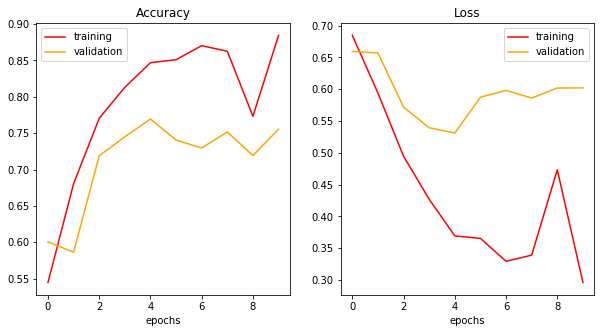

In [24]:
plot_graphs(history_simple, epoches)

In [25]:
loss_simple, accuracy_simple = model_simple.evaluate(X_test, y_test)

25000/25000 [==============================] - 55s 2ms/step


In [26]:
print('Loss: ', loss_simple)

Loss:  0.5891974123573304


In [27]:
print('Accuracy: ', accuracy_simple)

Accuracy:  0.7613199949264526


In [28]:
model_simple.save('models/simpleRNN.h5')

### LSTM rekurentna neuronska mreža 

In [29]:
embedding_dimensionality = 64
units = 64

In [30]:
model_lstm = Sequential()
model_lstm.add(Embedding(max_features, embedding_dimensionality, input_length=maxlen))
model_lstm.add(LSTM(units))
model_lstm.add(Dense(1, activation='sigmoid'))

In [31]:
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 64)           640000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 673,089
Trainable params: 673,089
Non-trainable params: 0
_________________________________________________________________


In [32]:
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
epoches = 10
batch_size = 64

In [34]:
# treniranje mreze traje nesto duze - istrenirani model je dostupan u models direktorijumu
start_training_lstm = perf_counter()
history_lstm = model_lstm.fit(X_train, y_train, epochs=epoches, batch_size=batch_size, validation_split=0.2)
end_training_lstm = perf_counter()

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 198s 10ms/step - loss: 0.4591 - accuracy: 0.7851 - val_loss: 0.3528 - val_accuracy: 0.8562
Epoch 2/10
20000/20000 [==============================] - 207s 10ms/step - loss: 0.2603 - accuracy: 0.8988 - val_loss: 0.3428 - val_accuracy: 0.8502
Epoch 3/10
20000/20000 [==============================] - 198s 10ms/step - loss: 0.1838 - accuracy: 0.9324 - val_loss: 0.3371 - val_accuracy: 0.8556
Epoch 4/10
20000/20000 [==============================] - 195s 10ms/step - loss: 0.1437 - accuracy: 0.9492 - val_loss: 0.3509 - val_accuracy: 0.8616
Epoch 5/10
20000/20000 [==============================] - 190s 10ms/step - loss: 0.1383 - accuracy: 0.9505 - val_loss: 0.3726 - val_accuracy: 0.8462
Epoch 6/10
20000/20000 [==============================] - 195s 10ms/step - loss: 0.1124 - accuracy: 0.9607 - val_loss: 0.4335 - val_accuracy: 0.8718
Epoch 7/10
20000/20000 [==============================] -

In [35]:
print('Duzina trajanja treniranja (u sekundama): ', end_training_lstm-start_training_lstm)

Duzina trajanja treniranja (u sekundama):  1954.1000787709997


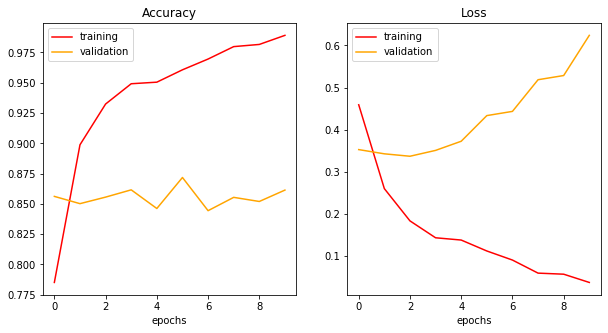

In [36]:
plot_graphs(history_lstm, epoches)

In [37]:
loss_lstm, accuracy_lstm = model_lstm.evaluate(X_test, y_test)

25000/25000 [==============================] - 85s 3ms/step


In [38]:
print('Loss: ', loss_lstm)

Loss:  0.6495069936710596


In [39]:
print('Accuracy: ', accuracy_lstm)

Accuracy:  0.8536400198936462


In [40]:
model_lstm.save('models/LSTM.h5')

### GRU rekurentna neuronska mreža 

In [41]:
embedding_dimensionality = 64
units = 64

In [42]:
model_gru = Sequential()
model_gru.add(Embedding(max_features, embedding_dimensionality, input_length=maxlen))
model_gru.add(GRU(units))
model_gru.add(Dense(1, activation='sigmoid'))

In [43]:
model_gru.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 64)           640000    
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                24768     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 664,833
Trainable params: 664,833
Non-trainable params: 0
_________________________________________________________________


In [44]:
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [45]:
epoches = 10
batch_size = 64

In [46]:
# treniranje mreze traje nesto duze - istrenirani model je dostupan u models direktorijumu
start_training_gru = perf_counter()
history_gru = model_gru.fit(X_train, y_train, epochs=epoches, batch_size=batch_size, validation_split=0.2)
end_training_gru = perf_counter()

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 179s 9ms/step - loss: 0.4496 - accuracy: 0.7873 - val_loss: 0.3294 - val_accuracy: 0.8584
Epoch 2/10
20000/20000 [==============================] - 169s 8ms/step - loss: 0.2542 - accuracy: 0.8992 - val_loss: 0.3246 - val_accuracy: 0.8752
Epoch 3/10
20000/20000 [==============================] - 164s 8ms/step - loss: 0.2025 - accuracy: 0.9248 - val_loss: 0.3380 - val_accuracy: 0.8672
Epoch 4/10
20000/20000 [==============================] - 167s 8ms/step - loss: 0.1506 - accuracy: 0.9457 - val_loss: 0.3788 - val_accuracy: 0.8720
Epoch 5/10
20000/20000 [==============================] - 170s 8ms/step - loss: 0.1235 - accuracy: 0.9556 - val_loss: 0.3902 - val_accuracy: 0.8710
Epoch 6/10
20000/20000 [==============================] - 171s 9ms/step - loss: 0.0954 - accuracy: 0.9670 - val_loss: 0.4461 - val_accuracy: 0.8714
Epoch 7/10
20000/20000 [==============================] - 160s 

In [47]:
print('Duzina trajanja treniranja: ', end_training_gru-start_training_gru)

Duzina trajanja treniranja:  1664.8856814220003


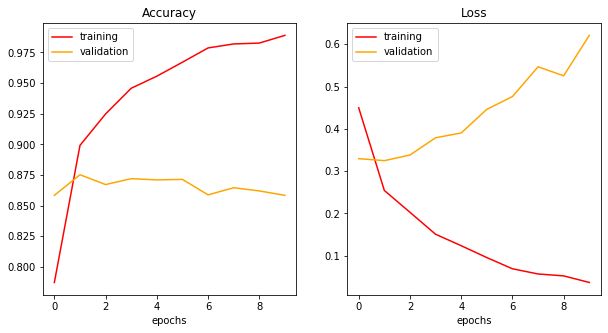

In [48]:
plot_graphs(history_gru, epoches)

In [49]:
loss_gru, accuracy_gru = model_gru.evaluate(X_test, y_test)

25000/25000 [==============================] - 64s 3ms/step


In [50]:
print('Loss: ', loss_gru)

Loss:  0.6808075505924225


In [51]:
print('Accuracy: ', accuracy_gru)

Accuracy:  0.8483999967575073


In [52]:
model_gru.save('models/GRU.h5')

### Neuronska mreža sa pritreniranim ugnježdavanjima

Isprobaćemo i varijantu mreže koja će koristiti pritrenirane ugnježdene reprezentacije. Ovakve reprezentacije se obično uče nad većim skupom podataka i mogu biti korisne za mnoge zadatke u kojima je raspoloživi skup mnogo manjeg obima. O načinima njihovog učenja biće više reči u sekciji o nenadgledanom mašinskom učenju, a ove ćemo iskoristiti `GloVe` reprezentacije. Ceo paket sa reprezentacijama reči različitih dužina (50, 100, 200 i 300) ukupne veličine 822MB se može preuzeti sa [zvanične adrese](https://nlp.stanford.edu/projects/glove/) Stanford grupe. Mi ćemo u radu koristiti reprezentacije dužine 100 koje se nalaze u datoteci `glove.6B.100d.txt` (347.1MB) koja se može preuzeti pojedinačno npr. sa [ove](https://www.kaggle.com/terenceliu4444/glove6b100dtxt) adrese. 

Prvo ćemo pročitati iz preuzete datoteke sve podržane reči i njihove vektorske reprezentacije. U pojedinačnim redovima datoteke se prvo nalazi reči, a potom 100 realnih vrednosti koje predstavljaju njenu vektorsku reprezentaciju.

In [53]:
word_embeddings = {}
f = open('data/glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = coefs
f.close()

In [54]:
len(word_embeddings)

400000

Na primer, vektorska reprezentacija reči `movie` se može dobiti sa:

In [55]:
word_embeddings['movie']

array([ 0.38251  ,  0.14821  ,  0.60601  , -0.51533  ,  0.43992  ,
        0.061053 , -0.62716  , -0.025385 ,  0.1643   , -0.22101  ,
        0.14423  , -0.37213  , -0.21683  , -0.08895  ,  0.097904 ,
        0.6561   ,  0.64455  ,  0.47698  ,  0.83849  ,  1.6486   ,
        0.88922  , -0.1181   , -0.012465 , -0.52082  ,  0.77854  ,
        0.48723  , -0.014991 , -0.14127  , -0.34747  , -0.29595  ,
        0.1028   ,  0.57191  , -0.045594 ,  0.026443 ,  0.53816  ,
        0.32257  ,  0.40788  , -0.043599 , -0.146    , -0.48346  ,
        0.32036  ,  0.55086  , -0.76259  ,  0.43269  ,  0.61753  ,
       -0.36503  , -0.60599  , -0.79615  ,  0.3929   , -0.23668  ,
       -0.34719  , -0.61201  ,  0.54747  ,  0.94812  ,  0.20941  ,
       -2.7771   , -0.6022   ,  0.8495   ,  1.2549   ,  0.017893 ,
       -0.041901 ,  2.1147   , -0.026618 , -0.28104  ,  0.68124  ,
       -0.14165  ,  0.99249  ,  0.49879  , -0.67538  ,  0.6417   ,
        0.42303  , -0.27913  ,  0.063403 ,  0.68909  , -0.3618

Prilikom učenja ovakvih reprezentacija obično se ne vrši priprema teksta na način koji smo opisivali u generisanju `Tf-Idf` reprezentacija (normalizacija, stemiranje, lematizacija) kako bi mreža mogla da nauči različite aspekte pojedinačnih reči. Tako za imenicu movie postoji i reprezentacija reči movies, a za glagol play i reprezentacije za plays, playing i played.

Da bismo mogli da mapiramo filmske izveštaje u reči, a potom i reči u vektorske reprezentacije, sa forme pregleda koji sadrži indekse reči trebamo preći na formu koja sadrži konkretne reči. 

Ovde ćemo simulirati ceo proces obrade teksta korišćenjem Keras podrške obrađujući orginalne tekstualne sadržaje pregleda koji se mogu preuzeti sa [ove](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) adrese.

In [56]:
import pandas as pd
import re

In [57]:
reviews = pd.read_csv('data/IMDB.csv')

U pročitanom skupu se nalaze svi pregledi koje treba dalje razvrstati na skupove za treniranje, validaciju i testiranje.

In [58]:
reviews.shape

(50000, 2)

In [59]:
reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Pozitivni sentiment ćemo mapirati u vrednost 1, a negativni u vrednost 0.

In [60]:
reviews['target'] = reviews['sentiment'].apply(lambda s: 1 if s=='positive' else 0)

In [61]:
reviews['target'].value_counts()

1    25000
0    25000
Name: target, dtype: int64

Zbog dalje obrade teksta, pročitaćemo i jedan originalni pregled.

In [62]:
demo_review = reviews.iloc[0]['review']

In [63]:
demo_review

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

Iz ovako pročitanih dokumenata možemo izbrisati zaostale HTML etikete i zameniti višestruke beline jednostrukim. Takođe, možemo sve zapisati malim slovima.

In [64]:
def prepare_review(review):
    clean_review = re.sub('<.+?>', ' ', review)
    clean_review = re.sub('\s+', ' ', clean_review)
    return clean_review.lower()

In [65]:
prepare_review(demo_review)

"one of the other reviewers has mentioned that after watching just 1 oz episode you'll be hooked. they are right, as this is exactly what happened with me. the first thing that struck me about oz was its brutality and unflinching scenes of violence, which set in right from the word go. trust me, this is not a show for the faint hearted or timid. this show pulls no punches with regards to drugs, sex or violence. its is hardcore, in the classic use of the word. it is called oz as that is the nickname given to the oswald maximum security state penitentary. it focuses mainly on emerald city, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. em city is home to many..aryans, muslims, gangstas, latinos, christians, italians, irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away. i would say the main appeal of the show is due to the fact that it goes where other shows

Ovako napisanu funkciju ćemo dalje primeniti nad svakim pregledom.

In [66]:
reviews['prepared_review'] = reviews['review'].apply(lambda r: prepare_review(r))

Dalje, da bismo izdvojili skup za treniranje, skup za validaciju i skup za testiranje, promešaćemo indekse skupova podataka - podrazumevano prvo imamo sve pozitivne preglede uzastopno, a zatim i sve negativne.

In [67]:
indices = np.arange(reviews.shape[0])
np.random.shuffle(indices)

Prateći brojke iz prethodnih primera, u test skup ćemo smestiti polovinu pregleda, a ostale ćemo podeliti na preglede za traniranje i validaciju.

In [68]:
number_of_reviews = reviews.shape[0]
test_reviews = reviews.iloc[indices[0:number_of_reviews//2]]
validation_size = int(0.2*number_of_reviews)
train_reviews = reviews.iloc[indices[0:number_of_reviews//2-validation_size]]
validation_reviews = reviews.iloc[indices[number_of_reviews//2-validation_size:number_of_reviews//2]]

In [69]:
test_reviews.shape

(25000, 4)

In [70]:
train_reviews.shape

(15000, 4)

In [71]:
validation_reviews.shape

(10000, 4)

Obradu ćemo izvršiti korišćenjem Kerasovog `Tokenizer` tokenizatora. Njime se mogu izdvojiti pojedinačne reči tj. tokeni zadatog teksta i konstruisati vokabular željene dužine. Kao i u prethodnim primerima, iskoristićemo 10000 najfrekventnijih reči.

In [72]:
from keras.preprocessing.text import Tokenizer

In [73]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(reviews['prepared_review'])

Vokabular koji je kreirao tokenizator se može dobiti pomoću `word_index` svojstva. On se sastoji od reči i indeksa njihovih pozicija.

In [74]:
word_index = tokenizer.word_index
print('Broj jedinstvenih reci (tokena): ', len(word_index))

Broj jedinstvenih reci (tokena):  123272


In [75]:
word_index['movie']

16

In [76]:
word_index['movies']

96

Na osnovu ovako dobijene mape i GloVe vrednosti kreiraćemo matricu ugnježdavanja nalik onoj koju je mreža učila do sada.

In [77]:
embedding_dimensionality = 100
number_of_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.zeros((number_of_words, embedding_dimensionality))

In [78]:
for word, i in word_index.items():
    if i >= max_features:
        continue
    embedding_vector = word_embeddings.get(word)
    
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
    # ukoliko rec teksta nema GloVe reprezentaciju, njoj ce odgovarati vektor nula

In [79]:
embedding_matrix.shape

(10000, 100)

Dalje ćemo korišćenjem tokenizatora transformisati tekst u niz indeksa reči. Za to ćemo koristiti njegovu metodu `text_to_sequence`. Potom ćemo dobijene sekvence svesti na istu dužinu korišćenjem funkcije `pad_sequence`.

In [80]:
train_sequences = tokenizer.texts_to_sequences(train_reviews['prepared_review'])
X_train = preprocessing.sequence.pad_sequences(train_sequences, maxlen = maxlen)
y_train = train_reviews['target']

In [81]:
test_sequences = tokenizer.texts_to_sequences(test_reviews['prepared_review'])
X_test = preprocessing.sequence.pad_sequences(test_sequences, maxlen = maxlen)
y_test = test_reviews['target']

In [82]:
validation_sequences = tokenizer.texts_to_sequences(validation_reviews['prepared_review'])
X_validation = preprocessing.sequence.pad_sequences(validation_sequences, maxlen = maxlen)
y_validation = validation_reviews['target']

Ostalo je još da kreiramo i naučimo model koji koiristi matricu ugnježdavanja. Prilikom zadavanja Embedding sloja ovoga puta ćemo preko parametra `weights` naglasiti koje vrednosti treba koristiti, a kako njih ne treba menjati u toku učenja, postavićemo i `trainable` parametar na vrednost `False`.

In [86]:
model_with_glove = Sequential()
model_with_glove.add(Embedding(max_features, embedding_dimensionality, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model_with_glove.add(Flatten())
model_with_glove.add(Dense(32, activation='relu'))
model_with_glove.add(Dense(1, activation='sigmoid'))
model_with_glove.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 50000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1600032   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 2,600,065
Trainable params: 1,600,065
Non-trainable params: 1,000,000
_________________________________________________________________


In [87]:
model_with_glove.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [88]:
epoches = 10
batch_size = 64

In [89]:
history_with_glove = model_with_glove.fit(X_train, y_train, batch_size=batch_size, epochs=epoches, validation_data=(X_validation, y_validation))

Train on 15000 samples, validate on 10000 samples
Epoch 1/10
15000/15000 [==============================] - 14s 900us/step - loss: 0.6911 - accuracy: 0.5751 - val_loss: 0.6547 - val_accuracy: 0.6489
Epoch 2/10
15000/15000 [==============================] - 13s 884us/step - loss: 0.5777 - accuracy: 0.7362 - val_loss: 0.6084 - val_accuracy: 0.6831
Epoch 3/10
15000/15000 [==============================] - 12s 783us/step - loss: 0.4507 - accuracy: 0.8378 - val_loss: 0.5856 - val_accuracy: 0.7193
Epoch 4/10
15000/15000 [==============================] - 13s 842us/step - loss: 0.3623 - accuracy: 0.8929 - val_loss: 0.5812 - val_accuracy: 0.7239
Epoch 5/10
15000/15000 [==============================] - 13s 870us/step - loss: 0.2972 - accuracy: 0.9289 - val_loss: 0.6483 - val_accuracy: 0.7203
Epoch 6/10
15000/15000 [==============================] - 21s 1ms/step - loss: 0.2419 - accuracy: 0.9518 - val_loss: 0.6166 - val_accuracy: 0.7110
Epoch 7/10
15000/15000 [==============================] - 

In [ ]:
plot_graphs(history_with_glove, epoches)

Vidimo da se ovaj tip mreže brzo preprilagođava skupu podataka i da ima smisla probati sa nešto drugačijim dimenzijama skupova za treniranje i testiranje. 

In [ ]:
loss_with_glove, accuracy_with_glove = model_with_glove.evaluate(X_test, y_test)

In [ ]:
print('Loss: ', loss_with_glove)

In [ ]:
print('Accuracy: ', accuracy_with_glove)

In [ ]:
model_with_glove.save('models/glove.h5')

### Zadaci: 
- Ispitati ponašanje mreža koje se duže treniraju. 
- Ispitati ponašanje mreža koje imaju nešto drugačije arhitekture i podešavanja. 